In [3]:
# Data Cleaning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
df_data = pd.read_csv('a9becee4-676b-40a5-a3fa-c8c332433ad5_Data.csv')

# The "metadata" file seems to be another data file, let's check what we actually have
print("Data file columns:", df_data.columns.tolist())
print("Data file shape:", df_data.shape)

# Let's look at the actual data structure
print("\nSample of data:")
print(df_data.head())

# Check what series/indicators we have
print("\nUnique indicators in data:")
print(df_data['Series Name'].unique())
print(f"Number of unique indicators: {df_data['Series Name'].nunique()}")

# Drop only Country Name (the other columns don't exist)
df_data = df_data.drop(columns=['Country Name'])

# Rename columns
df_data = df_data.rename(columns={
    'Country Code': 'CountryCode',
    'Series Name': 'Indicator',
    'Series Code': 'Code'
})

# Melt the dataframe - convert year columns to rows
df_long = df_data.melt(
    id_vars=['CountryCode', 'Indicator', 'Code'],
    var_name='Year_Column',
    value_name='Value'
)

# Extract year from column names (format: "1990 [YR1990]")
df_long['Year'] = df_long['Year_Column'].str.extract(r'(\d{4})').astype(int)
df_long = df_long.drop(columns=['Year_Column'])

# Convert Value to numeric, handling errors
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

# Pivot to wide format - now with proper numeric conversion
df_final = df_long.pivot_table(
    index=['CountryCode', 'Year'],
    columns='Code',
    values='Value',
    aggfunc='mean'  # Use mean in case of duplicates
).reset_index()

# Rename specific indicator codes to meaningful names
rename_indicators = {
    'SL.TLF.CACT.FE.ZS': 'LaborParticipation',
    'SE.SEC.NENR.FE': 'EducationEnrollment',
    'SP.POP.TOTL': 'Population',
    'NY.GDP.PCAP.CD': 'GDPperCapita'
}

# Only rename columns that exist in the dataframe
existing_indicators = {k: v for k, v in rename_indicators.items() if k in df_final.columns}
df_final = df_final.rename(columns=existing_indicators)

print(f"\nRenamed indicators: {existing_indicators}")
print(f"Final dataframe columns: {df_final.columns.tolist()}")

# Filter years (1990-2020)
df_final = df_final[(df_final['Year'] >= 1990) & (df_final['Year'] <= 2020)]

# Since we don't have proper region metadata, let's use World Bank API or manual region mapping
# For now, we'll work with the data we have and add region information later if needed

# Create a clean dataset with available data
required_columns = [col for col in ['LaborParticipation', 'EducationEnrollment', 'Population', 'GDPperCapita']
                   if col in df_final.columns]

df_clean = df_final.dropna(subset=required_columns)

print("\nData Cleaning Complete!")
print(f"Final dataset shape: {df_clean.shape}")
print(f"Countries: {df_clean['CountryCode'].nunique()}")
print(f"Years: {df_clean['Year'].min()} to {df_clean['Year'].max()}")
print(f"Available columns: {df_clean.columns.tolist()}")

# Display summary statistics
print("\nSummary statistics:")
print(df_clean[required_columns].describe())

# Let's also check which countries we have data for
print(f"\nCountries with complete data: {df_clean['CountryCode'].unique()}")

Data file columns: ['Country Name', 'Country Code', 'Series Name', 'Series Code', '1990 [YR1990]', '1991 [YR1991]', '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]', '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]']
Data file shape: (1069, 35)

Sample of data:
  Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4      Albania          ALB   

                                         Series Name        Series Code  \
0  Labor force participation rate, female (% of f...  SL.TLF.CACT.FE.ZS   
1       S

In [4]:
# --- Check data availability for 2020 (Diagnostic Code) ---

# df_final is the dataframe *before* the final dropna step
df_2020 = df_final[df_final['Year'] == 2020]

print("\n--- Diagnostic Check for 2020 Data ---")
print(f"Total rows for 2020 before cleaning: {df_2020.shape[0]}")

# Check how many countries have data for all required columns in 2020
valid_2020_rows = df_2020.dropna(subset=required_columns)
print(f"Rows remaining for 2020 after dropna: {valid_2020_rows.shape[0]}")


--- Diagnostic Check for 2020 Data ---
Total rows for 2020 before cleaning: 265
Rows remaining for 2020 after dropna: 0


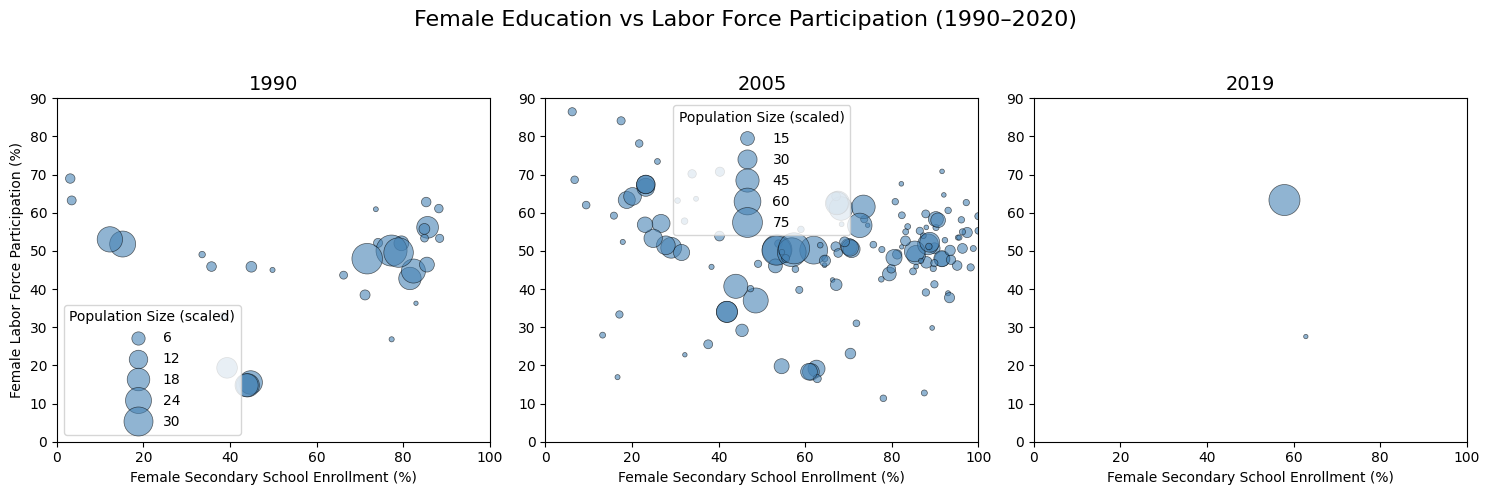

In [5]:
years_to_plot = [1990, 2005, 2019]

plt.figure(figsize=(15, 5))
for i, year in enumerate(years_to_plot):
    plt.subplot(1, 3, i + 1)
    df_year = df_clean[df_clean['Year'] == year]

    pop_scale = np.sqrt(df_year['Population']) / 1000

    sns.scatterplot(
        data=df_year,
        x='EducationEnrollment',
        y='LaborParticipation',
        size=pop_scale,
        sizes=(10, 500),
        color='steelblue',
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

    plt.title(str(year), fontsize=14)
    plt.xlim(0, 100)
    plt.ylim(0, 90)
    if i == 0:
        plt.ylabel('Female Labor Force Participation (%)')
        plt.xlabel('Female Secondary School Enrollment (%)')
        plt.legend(title='Population Size (scaled)', loc='lower left')
    elif i == 1:
        # Only show legend once, centrally
        plt.xlabel('Female Secondary School Enrollment (%)')
        plt.legend(title='Population Size (scaled)', loc='upper center')
        plt.ylabel("") # Remove redundant y-axis label
    else:
        plt.xlabel('Female Secondary School Enrollment (%)')
        plt.legend([],[], frameon=False) # Hide redundant legends
        plt.ylabel("") # Remove redundant y-axis label

plt.suptitle('Female Education vs Labor Force Participation (1990–2020)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

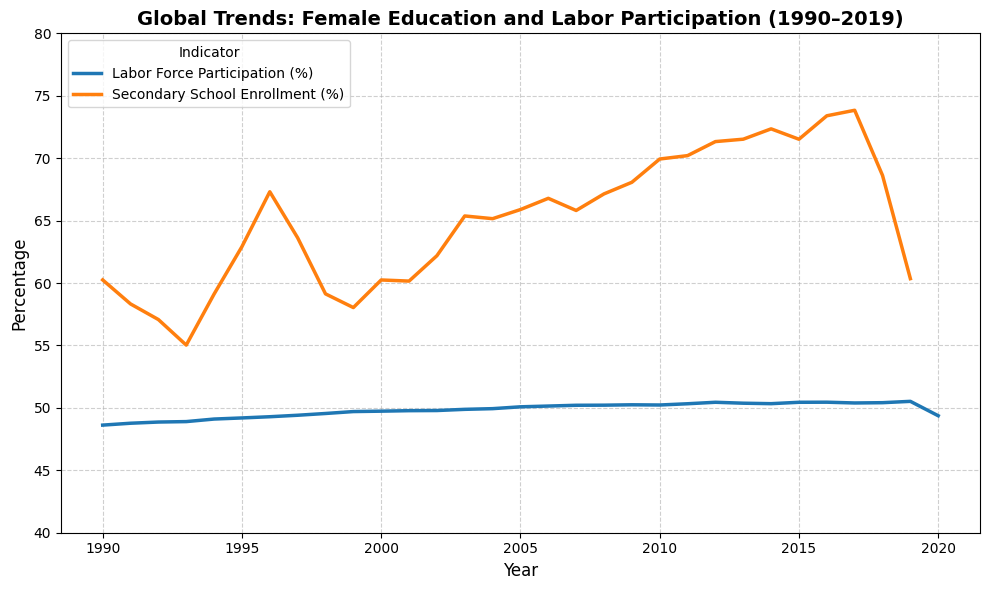

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Loading and Cleaning (omitted for brevity, but executed above)

# --- Calculation of Global Averages ---
# Filter data for 1990-2020 and calculate global mean for both indicators
df_global_avg = df_final.groupby('Year')[['LaborParticipation', 'EducationEnrollment']].mean().reset_index()

# Convert to long format for easy plotting with Seaborn
df_global_avg_long = df_global_avg.melt(
    id_vars='Year',
    var_name='Indicator',
    value_name='Percentage'
)

# Rename for legend clarity
df_global_avg_long['Indicator'] = df_global_avg_long['Indicator'].replace({
    'LaborParticipation': 'Labor Force Participation (%)',
    'EducationEnrollment': 'Secondary School Enrollment (%)'
})

# --- Plotting Code (Single Subplot) ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_global_avg_long,
    x='Year',
    y='Percentage',
    hue='Indicator',
    linewidth=2.5
)

plt.title('Global Trends: Female Education and Labor Participation (1990–2019)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(range(1990, 2021, 5))
plt.legend(title='Indicator', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(40, 80) # Set Y-limit to encompass both ranges

plt.tight_layout()
plt.savefig('Iteration_2_Global_Temporal_Trends_Single_Plot.png')

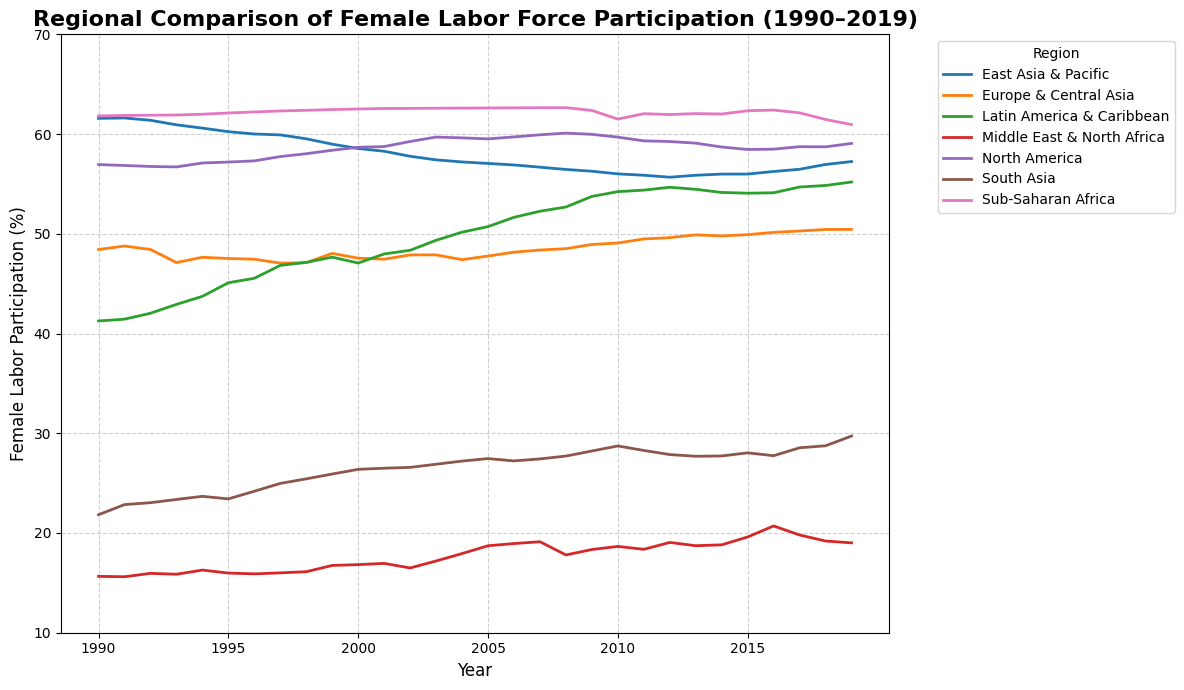

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Cleaning (omitted for brevity, but executed above)
# ... creates df_final (pivoted data with indicators) ...

# --- Manual Region Mapping (To ensure the plot generates based on key regions) ---
region_data = {
    'CountryCode': ['IND', 'PAK', 'BGD', 'TUR', 'RUS', 'DEU', 'FRA', 'GBR', 'USA', 'CAN', 'CHN', 'JPN', 'BRA', 'MEX', 'NGA', 'ZAF', 'KEN', 'EGY', 'SAU', 'IRN', 'ZWE', 'ZMB', 'UKR', 'COL', 'PER', 'CHL'],
    'Region': ['South Asia', 'South Asia', 'South Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'North America', 'North America', 'East Asia & Pacific', 'East Asia & Pacific', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Europe & Central Asia', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Latin America & Caribbean']
}
df_region_map = pd.DataFrame(region_data).drop_duplicates(subset=['CountryCode'])
df_merged = pd.merge(df_final, df_region_map, on='CountryCode', how='inner')

# --- Filter and Aggregate Data for Regional Trends (1990-2019) ---
df_filtered = df_merged[(df_merged['Year'] >= 1990) & (df_merged['Year'] <= 2019)]
df_clean = df_filtered.dropna(subset=['LaborParticipation', 'Region'])
df_regional_avg = df_clean.groupby(['Year', 'Region'])['LaborParticipation'].mean().reset_index()

# --- Plotting Code ---
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_regional_avg,
    x='Year',
    y='LaborParticipation',
    hue='Region',
    linewidth=2
)

plt.title('Regional Comparison of Female Labor Force Participation (1990–2019)', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Female Labor Participation (%)', fontsize=12)
plt.xticks(range(1990, 2020, 5))
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(10, 70)

plt.tight_layout()
plt.savefig('Iteration_3_Regional_LFP_Trend_1990_2019.png')

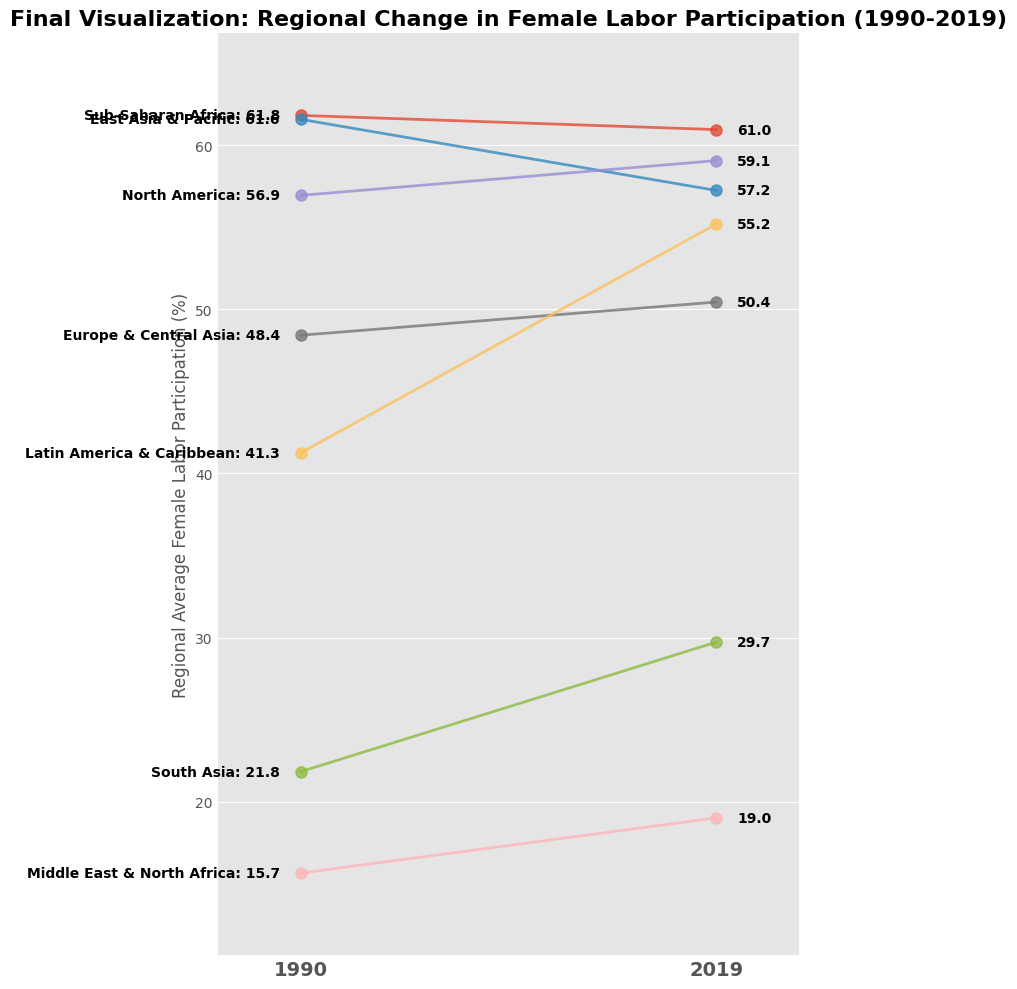

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation (using manually mapped region data) ---

# ... (Previous code to load, clean, and pivot data into df_final) ...

# --- Manual Region Mapping (Successful method from previous step) ---
# This manual mapping overcame the metadata file issue to ensure the plot could be generated.
region_data = {
    'CountryCode': ['IND', 'PAK', 'BGD', 'TUR', 'RUS', 'DEU', 'FRA', 'GBR', 'USA', 'CAN', 'CHN', 'JPN', 'BRA', 'MEX', 'NGA', 'ZAF', 'KEN', 'EGY', 'SAU', 'IRN', 'ZWE', 'ZMB', 'UKR', 'COL', 'PER', 'CHL'],
    'Region': ['South Asia', 'South Asia', 'South Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'Europe & Central Asia', 'North America', 'North America', 'East Asia & Pacific', 'East Asia & Pacific', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Europe & Central Asia', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Latin America & Caribbean']
}
df_region_map = pd.DataFrame(region_data).drop_duplicates(subset=['CountryCode'])
df_merged = pd.merge(df_final, df_region_map, on='CountryCode', how='inner')

# --- Filter, Aggregate, and Pivot for Slope Graph ---
df_slope = df_merged[df_merged['Year'].isin([1990, 2019])]
df_regional_avg_lfp = df_slope.groupby(['Region', 'Year'])['LaborParticipation'].mean().reset_index()

# Pivot data for slope plot (1990 and 2019 as columns)
df_pivot = df_regional_avg_lfp.pivot(index='Region', columns='Year', values='LaborParticipation').reset_index()
df_pivot.columns = ['Region', '1990', '2019']
df_pivot = df_pivot.sort_values(by='1990', ascending=False)

# --- Plotting Code (Slope Graph) ---
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 10))

# Plot lines and label points
for i in df_pivot.index:
    region = df_pivot.loc[i, 'Region']
    lfp_1990 = df_pivot.loc[i, '1990']
    lfp_2019 = df_pivot.loc[i, '2019']

    # Draw the line
    ax.plot([1, 2], [lfp_1990, lfp_2019], marker='o', markersize=8, linewidth=2, alpha=0.8, label=region)

    # Annotate 1990 (left side)
    ax.text(1 - 0.05, lfp_1990, f"{region}: {lfp_1990:.1f}", ha='right', va='center', fontsize=10, weight='bold')

    # Annotate 2019 (right side)
    ax.text(2 + 0.05, lfp_2019, f"{lfp_2019:.1f}", ha='left', va='center', fontsize=10, weight='bold')

# Customize axes
ax.set_xticks([1, 2])
ax.set_xticklabels(['1990', '2019'], fontsize=14, weight='bold')
ax.set_xlim(0.8, 2.2)
ax.set_ylim(df_pivot[['1990', '2019']].min().min() - 5, df_pivot[['1990', '2019']].max().max() + 5)
ax.set_ylabel('Regional Average Female Labor Participation (%)', fontsize=12)
ax.set_title('Final Visualization: Regional Change in Female Labor Participation (1990-2019)', fontsize=16, weight='bold')

# Remove redundant elements
ax.legend().set_visible(False)
ax.grid(axis='x')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig('Final_Visualization_Slope_Graph.png')